In [10]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [12]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/apollo2506/eurosat-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading eurosat-dataset.zip to .\eurosat-dataset


100%|██████████| 2.04G/2.04G [1:34:27<00:00, 387kB/s]  


In [23]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import rasterio
from torchvision import models #This is a module in torchvision that provides pre-trained deep learning models, including ResNet-50


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')



There are two paths: one for JPG files and another for TIF files. We will work on the JPG files and remove the EuroSAT all bands.




In [4]:
eurosat_allbands_path = "/content/eurosat-dataset/EuroSATallBands"
eurosat_testcsv_path = "/content/eurosat-dataset/EuroSAT/test.csv"
eurosat_traincsv_path = "/content/eurosat-dataset/EuroSAT/train.csv"
eurosat_validcsv_path = "/content/eurosat-dataset/EuroSAT/validation.csv"
json_file = '/content/eurosat-dataset/EuroSAT/label_map.json'

# Remove folder if it exists
if os.path.exists(eurosat_allbands_path) and os.path.isdir(eurosat_allbands_path):
    shutil.rmtree(eurosat_allbands_path)
    print(f"Folder '{eurosat_allbands_path}' removed successfully.")
else:
    print(f"Folder '{eurosat_allbands_path}' does not exist.")

# Function to remove a file safely
def remove_file(file_path):
    if os.path.exists(file_path) and os.path.isfile(file_path):
        os.remove(file_path)
        print(f"File '{file_path}' removed successfully.")
    else:
        print(f"File '{file_path}' does not exist.")

# Remove CSV files
remove_file(eurosat_testcsv_path)
remove_file(eurosat_traincsv_path)
remove_file(eurosat_validcsv_path)
remove_file(json_file)

Folder '/content/eurosat-dataset/EuroSATallBands' does not exist.
File '/content/eurosat-dataset/EuroSAT/test.csv' does not exist.
File '/content/eurosat-dataset/EuroSAT/train.csv' does not exist.
File '/content/eurosat-dataset/EuroSAT/validation.csv' does not exist.
File '/content/eurosat-dataset/EuroSAT/label_map.json' does not exist.


In [5]:
# CustomDataset class for loading images and labels
# So we use this function to shuffle all of those files all together to make 1 file for train and 1 file for test
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # List of classes (e.g., AnnualCrop, Forest)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.image_paths = []

        # Collect all image paths and labels
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            # Only consider directories (skip files like label_map.json)
            if os.path.isdir(class_dir):
                for img in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img)
                    # Only add image files
                    if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                        self.image_paths.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB images
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Define transformations for training (with augmentation)
# We apply augmentation for train only to avoid data leakage and ensure fair evaluation.
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip vertically
    transforms.RandomRotation(30),  # Randomly rotate by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define transformations for validation and testing (without augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the dataset using CustomDataset
data_dir = r".\eurosat-dataset\EuroSAT"
dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)  # Default transform for all data

# Split the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    dataset.image_paths, [label for _, label in dataset.image_paths], test_size=0.2, random_state=42,
    stratify=[label for _, label in dataset.image_paths]
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

# Create datasets for train, validation, and test
train_dataset = CustomDataset(root_dir=data_dir, transform=train_transform)
train_dataset.image_paths = train_paths

val_dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)
val_dataset.image_paths = val_paths

test_dataset = CustomDataset(root_dir=data_dir, transform=val_test_transform)
test_dataset.image_paths = test_paths

In [7]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,num_workers=0, shuffle=False)

# Print dataset sizes
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Total images: 27000
Training images: 19440
Validation images: 2160
Testing images: 5400


In [19]:
import rasterio

# Read a sample image
sample_img_path = dataset.image_paths[0][0]
with rasterio.open(sample_img_path) as img:
    num_bands = img.count
    print(f"Number of spectral bands: {num_bands}")

    # Read all bands as an array
    band_data = img.read()

    # Compute stats for each band
    for i in range(num_bands):
        band = band_data[i, :, :]
        print(f"Band {i+1} - Min: {band.min()}, Max: {band.max()}, Mean: {band.mean()}, Std: {band.std()}")

c:\Users\DELL\anaconda3-updated\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Number of spectral bands: 3
Band 1 - Min: 82, Max: 204, Mean: 109.10888671875, Std: 15.522078502128181
Band 2 - Min: 84, Max: 158, Mean: 97.437744140625, Std: 9.31978695547669
Band 3 - Min: 92, Max: 152, Mean: 104.853515625, Std: 6.950334927838432


In [20]:
# Missing/Corrupted Files
corrupted_files = []
for img_path, _ in dataset.image_paths:
    try:
        img = Image.open(img_path)  # Attempt to open with PIL
        img.verify()  # Verify file integrity
    except (IOError, SyntaxError) as e:
        corrupted_files.append(img_path)
        print(f"Corrupted file: {img_path}")

print(f"Total corrupted files: {len(corrupted_files)}")

Total corrupted files: 0


Training set samples:


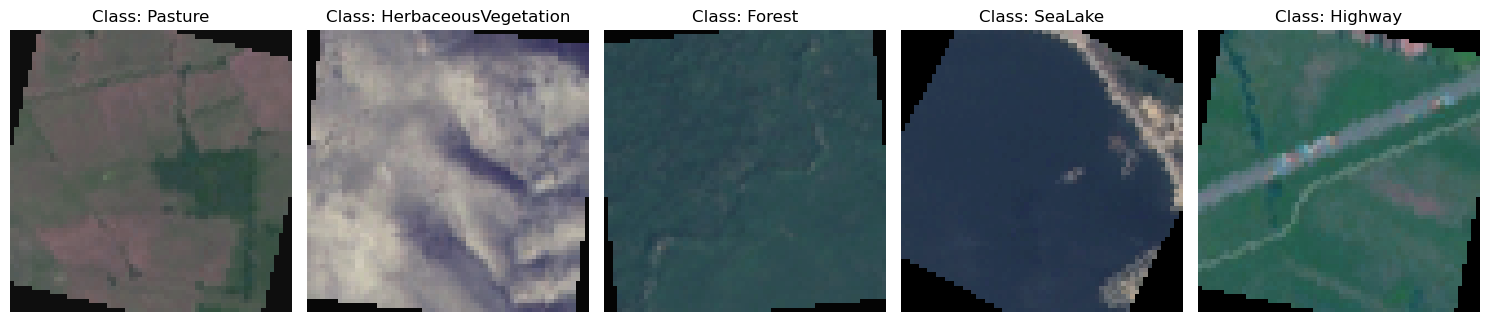

Validation set samples:


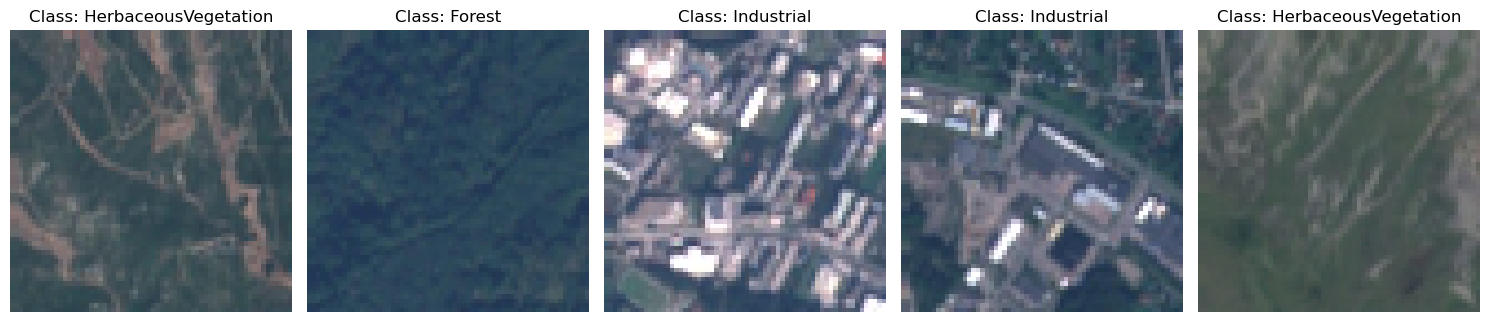

Testing set samples:


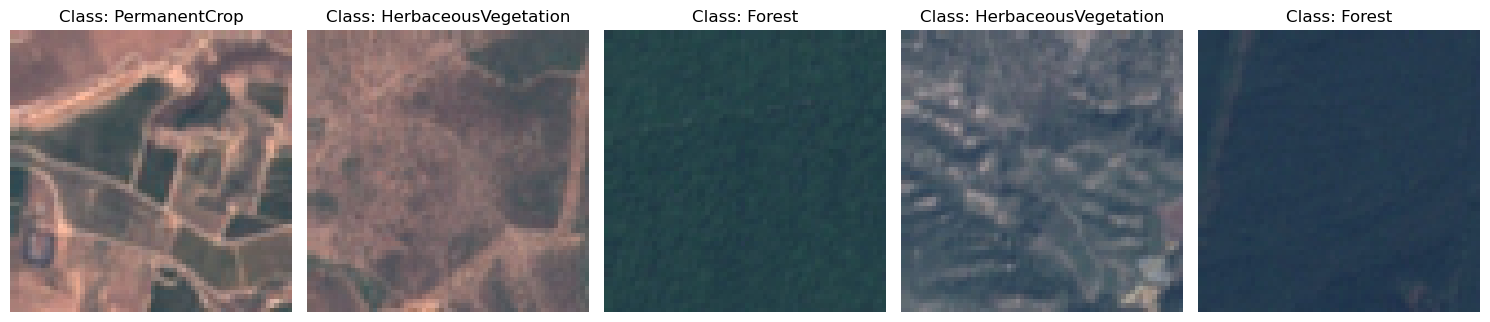

In [21]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_samples)  # Select random indices

    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5  # Undo normalization for visualization
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize random samples from train, validation, and test sets
print("Training set samples:")
visualize_samples(train_dataset, num_samples=5)

print("Validation set samples:")
visualize_samples(val_dataset, num_samples=5)

print("Testing set samples:")
visualize_samples(test_dataset, num_samples=5)

c:\Users\DELL\anaconda3-updated\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3-updated\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3-updated\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\DELL\anaconda3-updated\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if p

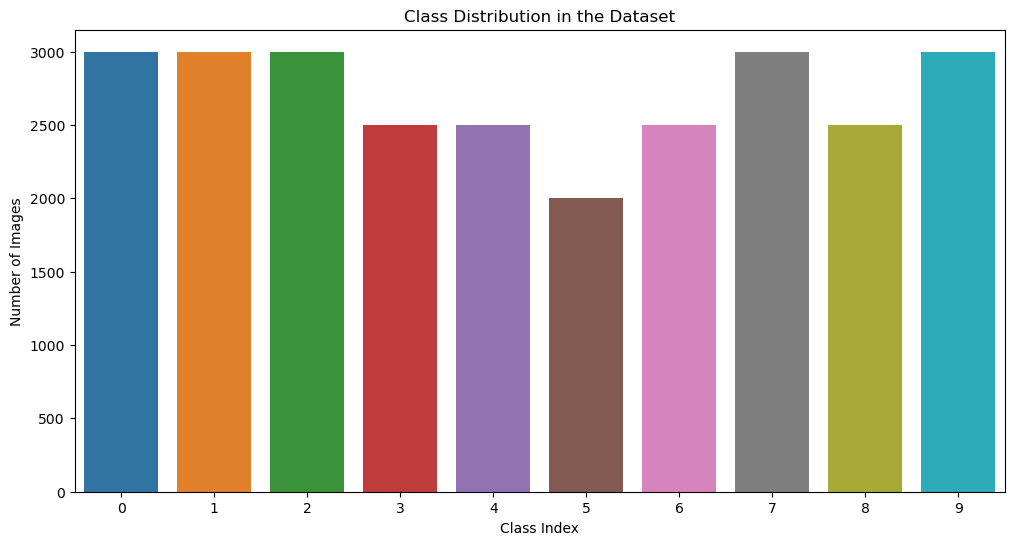

In [22]:
# Count the number of images per class
class_counts = Counter([label for _, label in dataset.image_paths])

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Class Distribution in the Dataset")
plt.show()

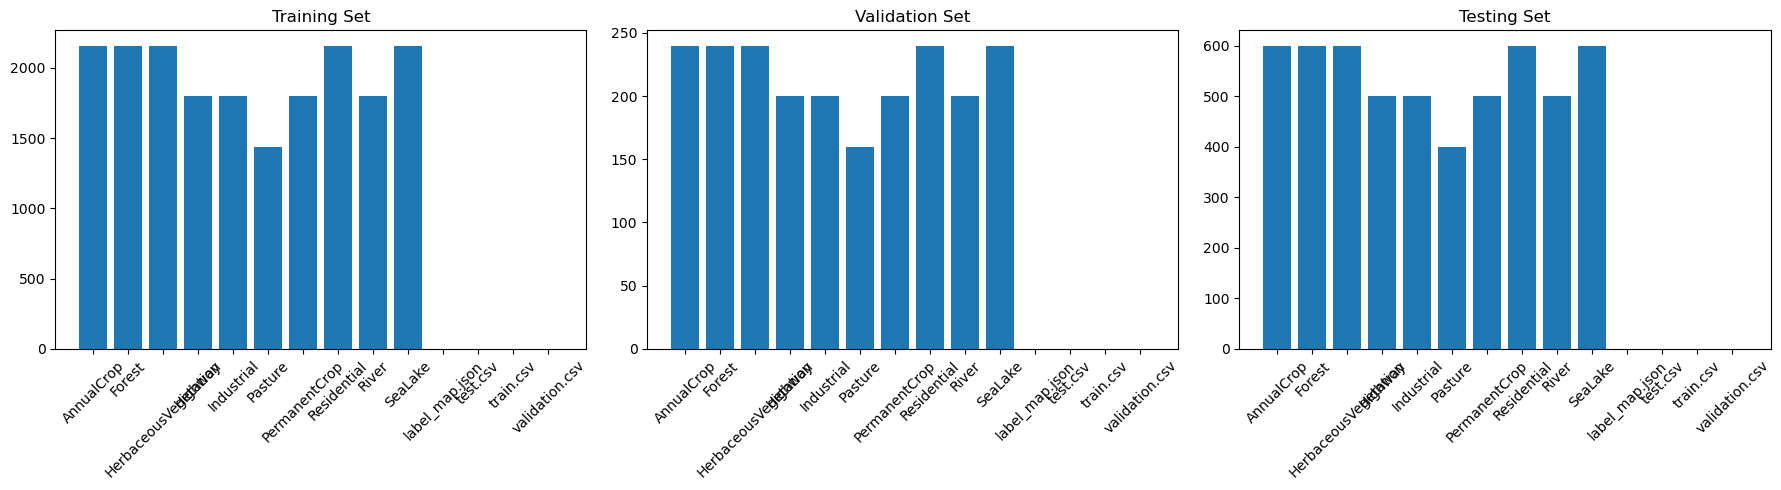

In [23]:
# Inspect Dataset Issues
# Function to plot class distribution in splits
def plot_split_distribution(train_labels, val_labels, test_labels, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Training set
    train_counts = Counter(train_labels)
    axes[0].bar(class_names, [train_counts[i] for i in range(len(class_names))])
    axes[0].set_title("Training Set")
    axes[0].tick_params(axis='x', rotation=45)

    # Validation set
    val_counts = Counter(val_labels)
    axes[1].bar(class_names, [val_counts[i] for i in range(len(class_names))])
    axes[1].set_title("Validation Set")
    axes[1].tick_params(axis='x', rotation=45)

    # Testing set
    test_counts = Counter(test_labels)
    axes[2].bar(class_names, [test_counts[i] for i in range(len(class_names))])
    axes[2].set_title("Testing Set")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_split_distribution(train_labels, val_labels, test_labels, dataset.classes)

# Bars for all classes are roughly the same height in all splits, the data is balanced.

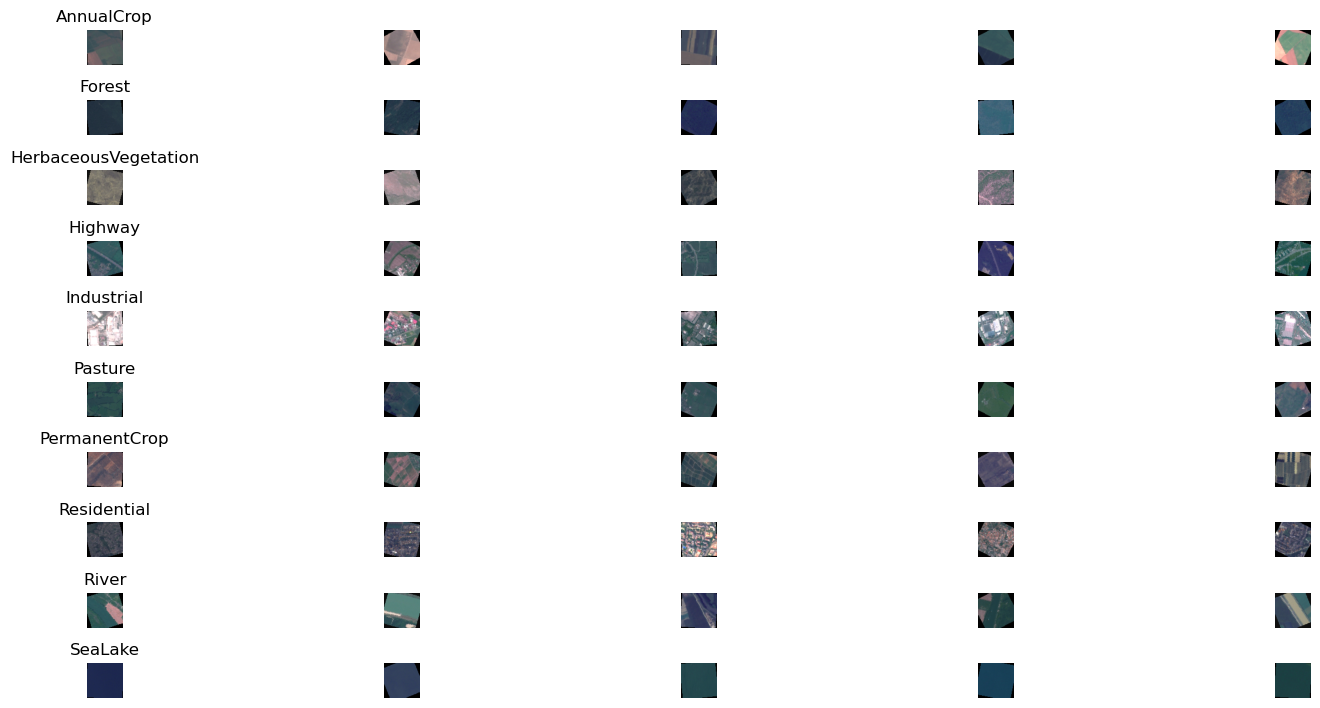

In [24]:
# Visualize Sample Images with RGB Analysis
def visualize_class_samples(dataset, num_samples=5):
    class_indices = {cls: [] for cls in dataset.classes}
    # Collect indices for each class
    for idx in range(len(dataset)):
        _, label = dataset.image_paths[idx]
        class_indices[dataset.classes[label]].append(idx)

    # Plot samples for each class
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(dataset.classes):
        indices = class_indices[cls][:num_samples]
        for j, idx in enumerate(indices):
            img, label = dataset[idx]
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Undo normalization
            plt.subplot(len(dataset.classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{cls}" if j == 0 else "")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_class_samples(train_dataset, num_samples=5)

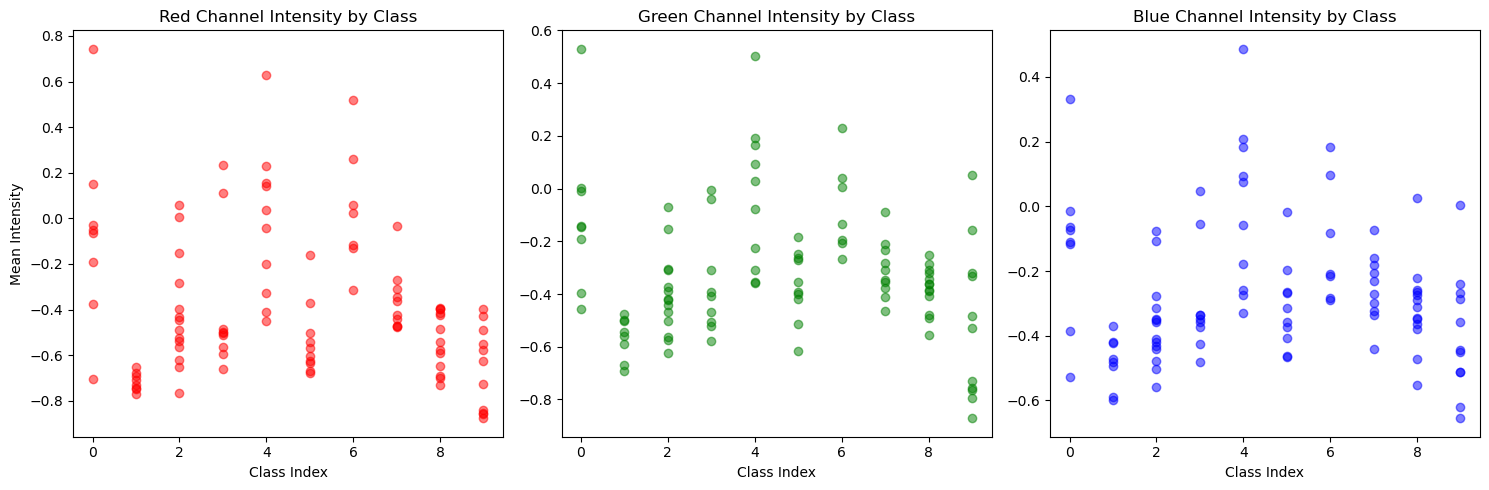

In [25]:
def plot_rgb_distributions(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel means
    r_means, g_means, b_means = [], [], []
    labels = []

    for idx in random_indices:
        img, label = dataset[idx]
        r_means.append(img[0].mean().item())
        g_means.append(img[1].mean().item())
        b_means.append(img[2].mean().item())
        labels.append(label)

    # Plot distributions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(labels, r_means, alpha=0.5, c='red')
    plt.title("Red Channel Intensity by Class")
    plt.xlabel("Class Index")
    plt.ylabel("Mean Intensity")

    plt.subplot(1, 3, 2)
    plt.scatter(labels, g_means, alpha=0.5, c='green')
    plt.title("Green Channel Intensity by Class")
    plt.xlabel("Class Index")

    plt.subplot(1, 3, 3)
    plt.scatter(labels, b_means, alpha=0.5, c='blue')
    plt.title("Blue Channel Intensity by Class")
    plt.xlabel("Class Index")

    plt.tight_layout()
    plt.show()

plot_rgb_distributions(train_dataset)

c:\Users\DELL\anaconda3-updated\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


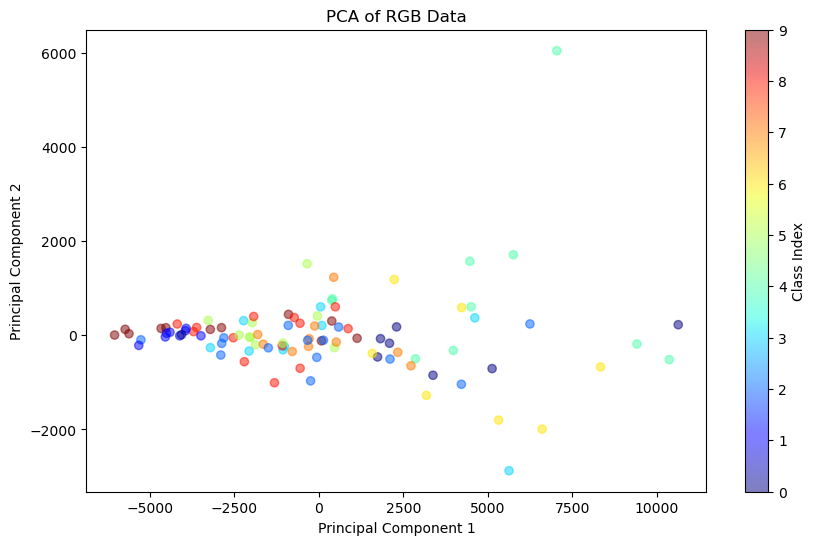

In [26]:
def plot_pca(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    spectral_data = []
    for idx in random_indices:
        with rasterio.open(dataset.image_paths[idx][0]) as img_raster:
            # Read the bands for RGB
            bands = [img_raster.read(i).flatten() for i in range(1, 4)]  # RGB channels
            spectral_data.append(np.concatenate(bands))

    spectral_data = np.array(spectral_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(spectral_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=[dataset.image_paths[idx][1] for idx in random_indices], cmap='jet', alpha=0.5)
    plt.title("PCA of RGB Data")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label="Class Index")
    plt.show()

plot_pca(train_dataset)

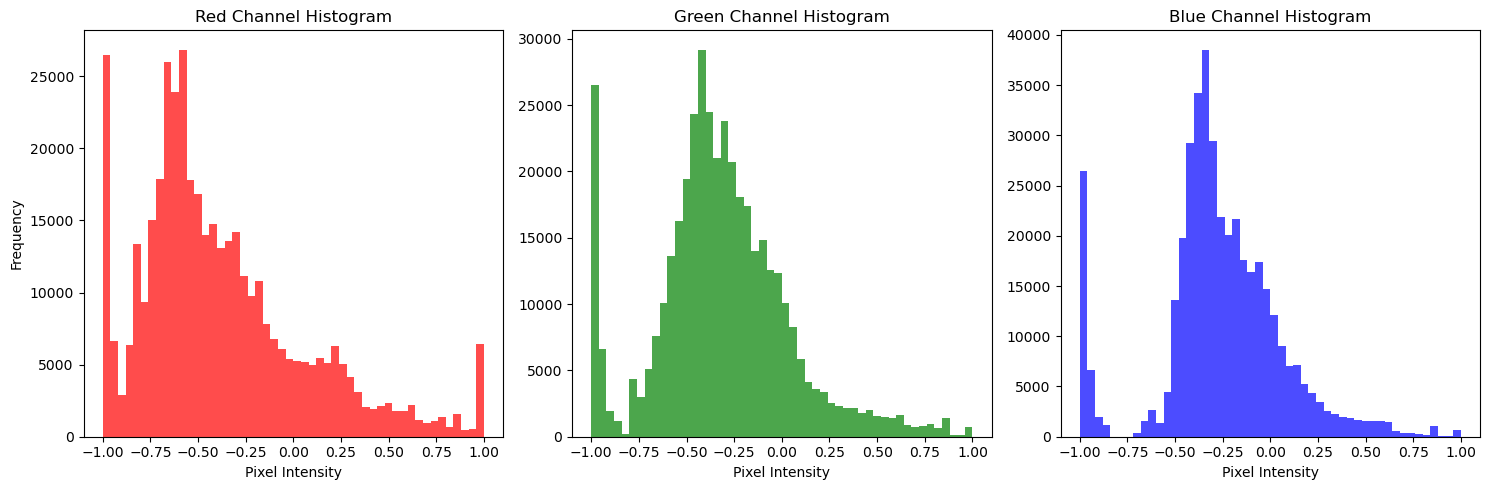

In [27]:
def plot_rgb_histograms(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel values
    r_values, g_values, b_values = [], [], []

    for idx in random_indices:
        img, _ = dataset[idx]
        r_values.extend(img[0].flatten().numpy())  # Flatten to get all pixel values
        g_values.extend(img[1].flatten().numpy())
        b_values.extend(img[2].flatten().numpy())

    # Plot histograms
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title("Red Channel Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title("Green Channel Histogram")
    plt.xlabel("Pixel Intensity")

    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title("Blue Channel Histogram")
    plt.xlabel("Pixel Intensity")

    plt.tight_layout()
    plt.show()

plot_rgb_histograms(train_dataset)

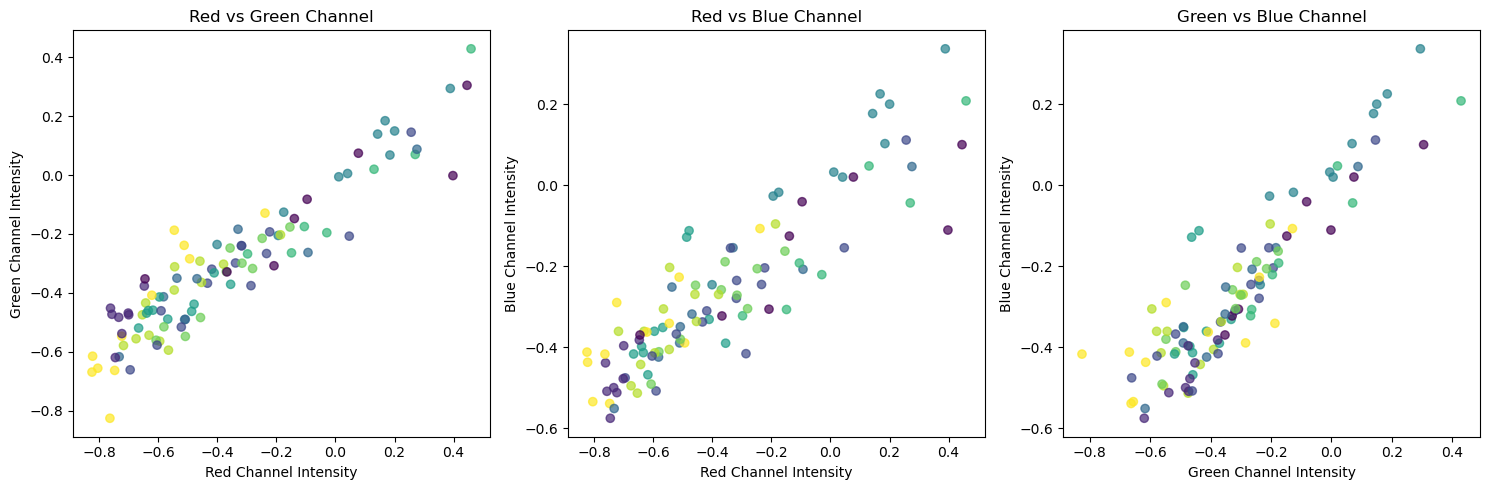

In [28]:
def plot_rgb_scatter(dataset, num_samples=100):
    np.random.seed(42)
    random_indices = np.random.randint(0, len(dataset), num_samples)

    # Initialize arrays to store channel values
    r_values, g_values, b_values = [], [], []
    labels = []

    for idx in random_indices:
        img, label = dataset[idx]
        r_values.append(img[0].mean().item())
        g_values.append(img[1].mean().item())
        b_values.append(img[2].mean().item())
        labels.append(label)

    # Plot scatter plots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(r_values, g_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Red vs Green Channel")
    plt.xlabel("Red Channel Intensity")
    plt.ylabel("Green Channel Intensity")

    plt.subplot(1, 3, 2)
    plt.scatter(r_values, b_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Red vs Blue Channel")
    plt.xlabel("Red Channel Intensity")
    plt.ylabel("Blue Channel Intensity")

    plt.subplot(1, 3, 3)
    plt.scatter(g_values, b_values, c=labels, cmap='viridis', alpha=0.7)
    plt.title("Green vs Blue Channel")
    plt.xlabel("Green Channel Intensity")
    plt.ylabel("Blue Channel Intensity")

    plt.tight_layout()
    plt.show()

plot_rgb_scatter(train_dataset)

we will develop our model ResNet-50 is a CNN model 

In [ ]:
from torchinfo import summary
import torch
model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc=torch.nn.Linear(model.fc.in_features,len(dataset.classes))
model=model.to(device)
summary(model,input_size=(1, 3, 224, 224)) # display model summary architecture
'''
Total Layer Count
Initial layers: 4
Bottleneck layers: 48
Final layers: 2
Total: 54 layers'''

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 14]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
from tqdm import tqdm #helps visualize how long a process will take
n_epochs = 10 
lr = 1e-3 #Determines how much the model updates its weights in each step.
loss_function = torch.nn.CrossEntropyLoss() #different the predicted class probabilities are from the actual class.
optimizer = torch.optim.SGD(model.parameters(),lr=lr)  #SGD (Stochastic Gradient Descent) is the optimization algorithm used to update the model’s parameters.

In [ ]:
def train(model, dataloader, loss_function , optimizer):    
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):  #Loops over the dataloader
    inputs = inputs.to(device)
    labels = labels.to(device)

    
    optimizer.zero_grad()   #Clears out the gradients from the previous batch.
                             #Without this step, PyTorch accumulates gradients from multiple batches,
                               #which can lead to incorrect weight updates.

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = loss_function(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step() 

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy


In [14]:
def evaluate(model, dataloader, loss_function, phase="val"):
    model.eval()
    running_loss = 0.0
    running_total_correct = 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloader)):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct.float() / len(dataloader.dataset)) * 100
    print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy


In [ ]:
def fit(model, train_loader, val_loader, n_epochs, loss_function, optimizer):
      # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf #Initially set to infinity so any lower validation loss will be considered.
  best_model = None #Will store the model with the lowest validation loss

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, loss_function, optimizer)
    val_loss, _ = evaluate(model, val_loader, loss_function)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

# Ensure train_loader and val_loader are not empty
assert len(train_loader) > 0, "Train loader is empty!"
assert len(val_loader) > 0, "Validation loader is empty!"



In [ ]:
model_1 = fit(model, train_loader, val_loader, n_epochs, loss_function, optimizer)

Epoch 1


100%|██████████| 608/608 [20:15<00:00,  2.00s/it] 


Train Loss: 2.12; Accuracy: 38.66


100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


Val Loss: 1.65; Accuracy: 59.44
Epoch 2


100%|██████████| 608/608 [09:11<00:00,  1.10it/s]


Train Loss: 1.09; Accuracy: 70.40


100%|██████████| 68/68 [00:16<00:00,  4.18it/s]


Val Loss: 0.84; Accuracy: 79.40
Epoch 3


100%|██████████| 608/608 [09:47<00:00,  1.04it/s]


Train Loss: 0.67; Accuracy: 79.91


100%|██████████| 68/68 [00:21<00:00,  3.14it/s]


Val Loss: 0.57; Accuracy: 84.44
Epoch 4


100%|██████████| 608/608 [11:40<00:00,  1.15s/it]


Train Loss: 0.51; Accuracy: 83.88


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Val Loss: 0.42; Accuracy: 88.94
Epoch 5


100%|██████████| 608/608 [11:39<00:00,  1.15s/it]


Train Loss: 0.44; Accuracy: 85.86


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Val Loss: 0.36; Accuracy: 89.86
Epoch 6


100%|██████████| 608/608 [11:36<00:00,  1.14s/it]


Train Loss: 0.39; Accuracy: 87.25


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Val Loss: 0.29; Accuracy: 91.71
Epoch 7


100%|██████████| 608/608 [12:10<00:00,  1.20s/it]


Train Loss: 0.36; Accuracy: 88.01


100%|██████████| 68/68 [00:54<00:00,  1.24it/s]


Val Loss: 0.26; Accuracy: 92.82
Epoch 8


100%|██████████| 608/608 [11:41<00:00,  1.15s/it]


Train Loss: 0.34; Accuracy: 88.67


100%|██████████| 68/68 [00:15<00:00,  4.32it/s]


Val Loss: 0.25; Accuracy: 92.82
Epoch 9


100%|██████████| 608/608 [08:09<00:00,  1.24it/s]


Train Loss: 0.31; Accuracy: 89.72


100%|██████████| 68/68 [00:14<00:00,  4.56it/s]


Val Loss: 0.22; Accuracy: 92.82
Epoch 10


100%|██████████| 608/608 [10:29<00:00,  1.04s/it]


Train Loss: 0.29; Accuracy: 90.29


100%|██████████| 68/68 [00:49<00:00,  1.36it/s]


Val Loss: 0.20; Accuracy: 93.52


Model Performance on the Test Set


In [ ]:
test_loss, _ = evaluate(model_1, test_loader, loss_function, phase="test")  # test our model 

100%|██████████| 169/169 [02:58<00:00,  1.06s/it]

Test Loss: 0.23; Accuracy: 93.15


Save Model 

In [16]:
import os
model_dir = "Land_Type_Classification"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'ResNet-50_model.pth')
model_file
     

'Land_Type_Classification\\ResNet-50_model.pth'

In [17]:
def save_model(model_1, model_file):
      torch.save(model_1.state_dict(), model_file)
print('Model successfully saved to {}.'.format(model_file))

Model successfully saved to Land_Type_Classification\ResNet-50_model.pth.


In [ ]:
save_model(model_1, model_file)

c:\Users\DELL\anaconda3-updated\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


NameError: name 'model_1' is not defined

In [21]:
def LoadModel(model_file="ResNet-50_model.pth"):
    # Ensure the file exists
    if not os.path.isfile(model_file):
        raise FileNotFoundError(f"Model file '{model_file}' not found.")

    # Load pre-trained ResNet-50 model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Modify the fully connected layer for 10 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 14)

    # Load the saved model weights
    try:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
        model.eval()
        print(f'Model file {model_file} successfully loaded.')
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None


In [24]:
model = LoadModel()

Model file ResNet-50_model.pth successfully loaded.


In [12]:
# Define EuroSAT class names
class_names = test_dataset.classes
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake',
 'label_map.json',
 'test.csv',
 'train.csv',
 'validation.csv']

In [44]:
# Define valid EuroSAT class names (excluding unwanted labels)
invalid_classes = {"label_map.json", "test.csv", "train.csv", "validation.csv"}

# Filter class names to remove invalid ones
class_names = [cls for cls in test_dataset.classes if cls not in invalid_classes]
print(class_names)  # Check the cleaned class names


['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [33]:
y_true = []
y_pred = []
y_score=[]

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, preds = torch.max(outputs, 1)  # Get predicted class
        
        # Store predictions and actual labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())  # Store full probability scores for PR curve


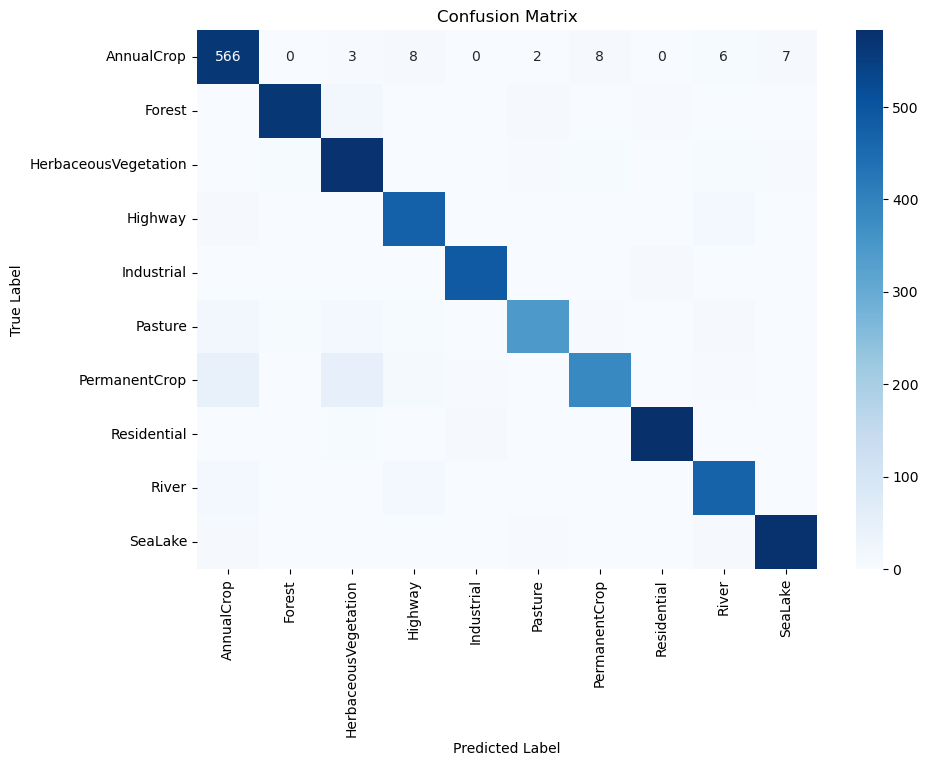

In [45]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import  precision_recall_fscore_support,precision_recall_curve
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9339
Recall: 0.9315
F1 Score: 0.9311


In [35]:
y_train_true = []
y_train_pred = []
y_train_scores = []  # For probability scores

# Evaluate on Training Set
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())
        y_train_scores.extend(probs.cpu().numpy())  # Store probability scores


In [37]:
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train_true, y_train_pred, average="weighted"
)

print(f" Training Precision: {train_precision:.4f}")
print(f" Training Recall: {train_recall:.4f}")
print(f" Training F1 Score: {train_f1:.4f}")

 Training Precision: 0.9355
 Training Recall: 0.9350
 Training F1 Score: 0.9349


In [52]:
print(f"🔵 Training Precision: {np.mean(train_precision):.4f}  |  🟠 Test Precision: {np.mean(precision):.4f}")
print(f"🔵 Training Recall: {np.mean(train_recall):.4f}  |  🟠 Test Recall: {np.mean(recall):.4f}")
print(f"🔵 Training F1 Score: {np.mean(train_f1):.4f}  |  🟠 Test F1 Score: {np.mean(f1):.4f}")


🔵 Training Precision: 0.9355  |  🟠 Test Precision: 0.3548
🔵 Training Recall: 0.9350  |  🟠 Test Recall: 0.9437
🔵 Training F1 Score: 0.9349  |  🟠 Test F1 Score: 0.9311


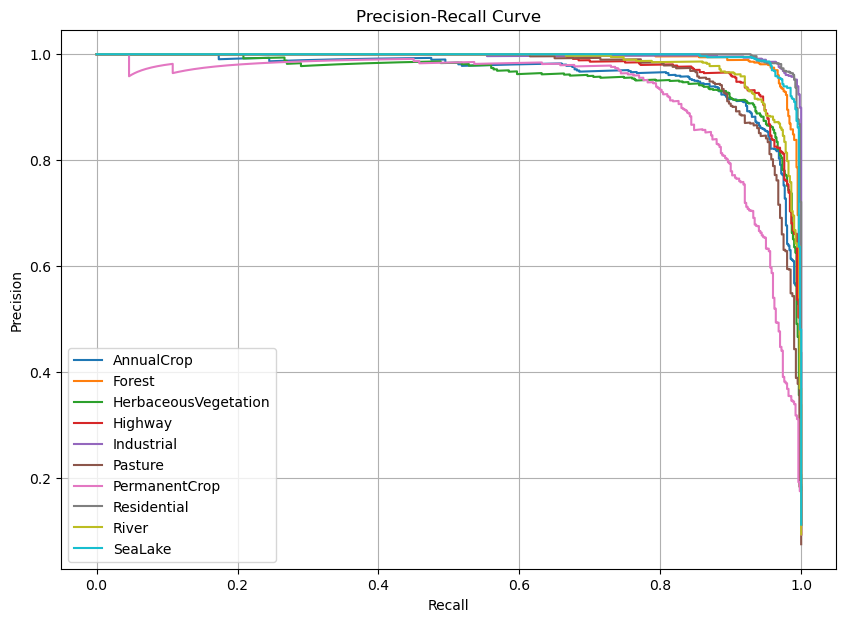

In [46]:
# Convert y_true to one-hot encoding for multi-class PR curve
y_true_one_hot = np.eye(len(class_names))[y_true]  # Convert to one-hot encoding

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], np.array(y_score)[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


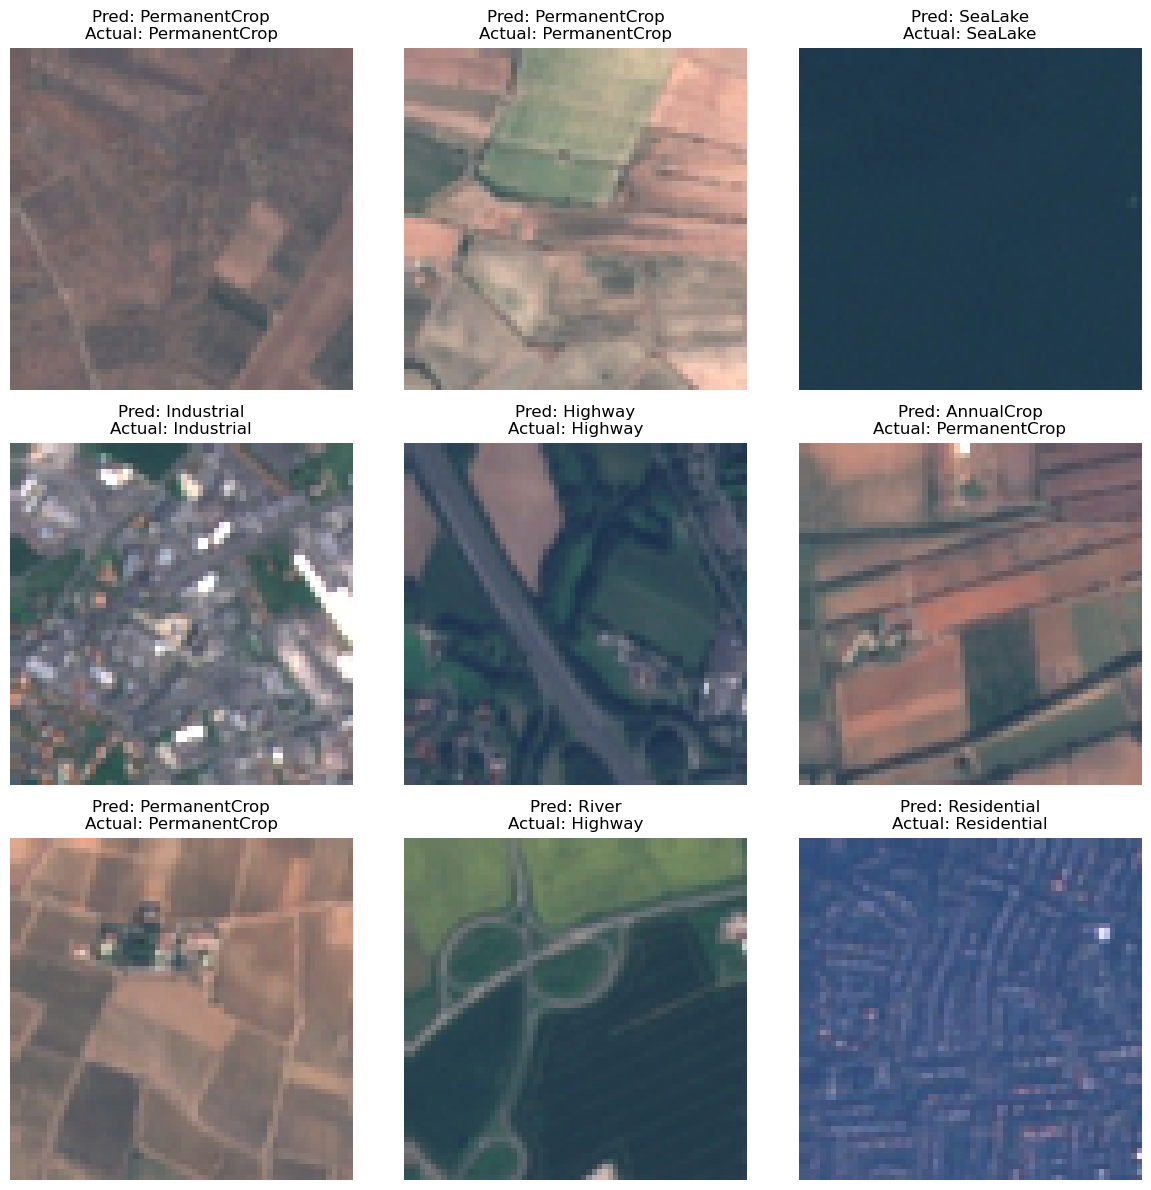

In [25]:
# Select nine random indices from test_dataset
random_indices = random.sample(range(len(test_dataset)), 9)

# Move model to CPU for inference
model = model.to("cpu")

# Plot the predictions
fig, axes = plt.subplots(3,3, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]  # Get image and actual label
    
    # Make prediction
    output = model(image.unsqueeze(0))  # Add batch dimension
    _, pred = torch.max(output, 1)  # Get the predicted class index
    
    # Convert indices to class names
    actual_class = class_names[label]
    predicted_class = class_names[pred.item()]
    
    # Convert image back to NumPy and de-normalize using dataset stats
    image = image.numpy().transpose((1, 2, 0))  # Convert to HWC format
    image = np.clip(image * 0.5 + 0.5, 0, 1)  # Undo normalization (assuming mean=0.5, std=0.5)

    # Display image
    ax = axes[i // 3, i % 3]# Position in grid (3 rows, 3 columns)
    ax.imshow(image)
    ax.set_title(f"Pred: {predicted_class}\nActual: {actual_class}")
    ax.axis("off")

plt.tight_layout()
plt.show()